## Preprocessing

Goal is to get an embedding of every path in a logo.  

Source: DeepSVG - A Hierarchical Generative Network for Vector Graphics Animation  
Paper: https://arxiv.org/abs/2007.11301  
Code: https://github.com/alexandre01/deepsvg

In [1]:
from IPython.display import SVG as svg_display, display
import pandas as pd
import pickle
import os
os.chdir("..")
os.chdir("src/preprocessing")
from create_embedding import preprocess_folder, train_embedding_model, apply_embedding_model, combine_embeddings, encode_logo, decode_z
from deepsvg.svglib.svg import SVG
from deepsvg import utils
os.chdir("../..")

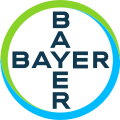

In [2]:
logo_name = "Bayer"
display(svg_display(f"data/svgs/{logo_name}.svg"))

### 1. Simplify SVGs

- Normalization: Scales logo to fit a 24x24 window.
- Unzoom: More free room on the borders of the image.
- Canonicalization: An SVG path is oriented clockwise and starts from the topmost-leftmost point.
- Simplification: Combination of Ramer-Douglas-Peucker and Philip J. Schneider algorithms to decimate a curve composed of line segments to a similar curve with fewer points

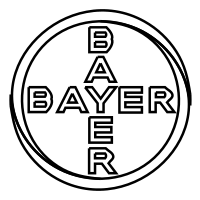

In [3]:
logo = SVG.load_svg(f"data/svgs/{logo_name}.svg")
logo.fill_(False).normalize().zoom(0.9)
logo = logo.canonicalize().simplify_heuristic()
logo.draw()

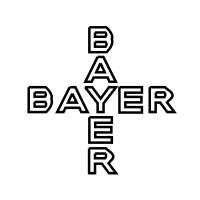

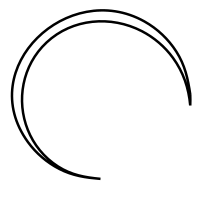

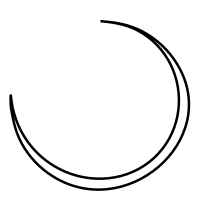

In [4]:
SVG.load_svg(f"data/decomposed_svgs_simplified/{logo_name}_0.svg").fill_(False).draw()
SVG.load_svg(f"data/decomposed_svgs_simplified/{logo_name}_1.svg").fill_(False).draw()
SVG.load_svg(f"data/decomposed_svgs_simplified/{logo_name}_2.svg").fill_(False).draw()

### 2. Create Tensors

In [5]:
tensor = logo.copy().numericalize().to_tensor(concat_groups=False)
pd.DataFrame(tensor[0].numpy()).drop([1, 2, 3, 4, 5], axis=1)

,0,6,7,8,9,10,11,12,13
0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,114.0,35.0
1,1.0,114.0,35.0,-1.0,-1.0,-1.0,-1.0,136.0,35.0
2,2.0,136.0,35.0,140.0,39.0,145.0,45.0,143.0,50.0
3,1.0,143.0,50.0,-1.0,-1.0,-1.0,-1.0,143.0,50.0
4,2.0,143.0,50.0,146.0,56.0,141.0,63.0,136.0,67.0
5,1.0,136.0,67.0,-1.0,-1.0,-1.0,-1.0,114.0,67.0
6,1.0,114.0,67.0,-1.0,-1.0,-1.0,-1.0,114.0,35.0


### 3. Train Hierarchical Generative Network

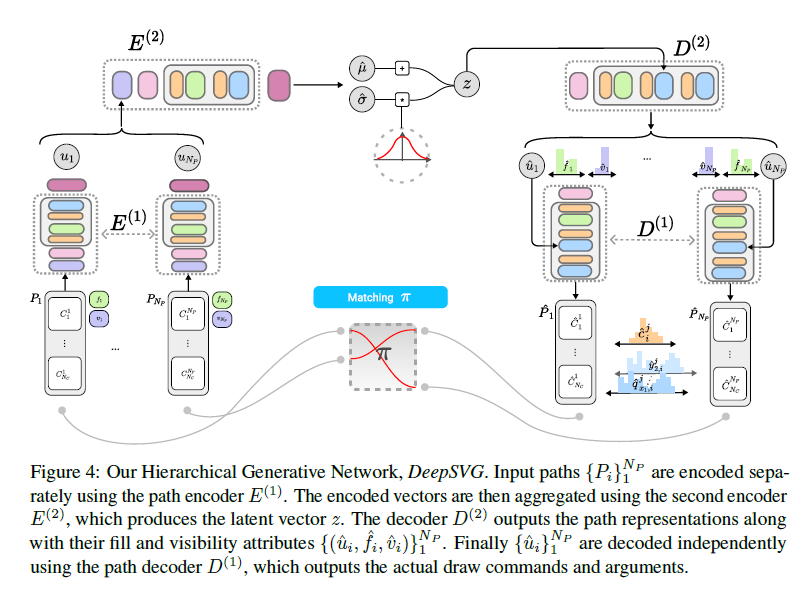

### 4. Create Embeddings with Hierarchical Generative Network

Get a latent vector z of logo and every path in a logo. Combine embeddings by taking the sum of logo and path embedding.

##### Path Embedding

In [6]:
with open('data/decomposed_svgs_embedding.pkl', 'rb') as f:
    decomposed_svgs_embedding = pickle.load(f)
decomposed_svgs_embedding[decomposed_svgs_embedding['filename'] == f"{logo_name}"]

,filename,animation_id,0,1,2,3,4,5,6,7,...,246,247,248,249,250,251,252,253,254,255
338,Bayer,0,-0.256135,-0.245227,0.315366,2.112953,-1.039598,1.389475,-0.506860,-1.404038,...,-0.190582,-0.163839,-0.057597,-1.561848,-0.236559,-0.676493,-1.789113,0.582033,-1.530049,0.182962
339,Bayer,1,0.748338,0.471301,0.939149,0.776502,-0.627101,-1.306191,0.431794,-0.031366,...,0.813771,2.098048,-0.542719,-1.771082,-1.862482,-0.349892,-0.176832,-0.022024,1.933769,1.007922
340,Bayer,2,0.378057,0.593513,0.123774,0.701279,-0.756043,-1.433412,1.485015,-0.425233,...,0.042306,0.420987,1.598208,-1.046733,-1.719785,-1.037928,0.327576,1.064473,2.007609,0.288089


##### Logo Embedding

In [7]:
with open('data/svgs_embedding.pkl', 'rb') as f:
    svgs_embedding = pickle.load(f)
svgs_embedding[svgs_embedding['filename'] == f"{logo_name}"]

,filename,0,1,2,3,4,5,6,7,8,...,246,247,248,249,250,251,252,253,254,255
13,Bayer,-0.256135,-0.245227,0.315366,2.112953,-1.039598,1.389475,-0.50686,-1.404038,-0.42369,...,-0.190582,-0.163839,-0.057597,-1.561848,-0.236559,-0.676493,-1.789113,0.582033,-1.530049,0.182962


##### Combined Embedding

In [8]:
with open('data/combined_embedding.pkl', 'rb') as f:
    combined_embedding = pickle.load(f)
combined_embedding[combined_embedding['filename'] == f"{logo_name}"]

,filename,animation_id,0,1,2,3,4,5,6,7,...,246,247,248,249,250,251,252,253,254,255
338,Bayer,0,-0.512270,-0.490453,0.630732,4.225906,-2.079197,2.778951,-1.013721,-2.808077,...,-0.381165,-0.327679,-0.115194,-3.123696,-0.473118,-1.352986,-3.578226,1.164066,-3.060098,0.365923
339,Bayer,1,0.492203,0.226075,1.254515,2.889455,-1.666699,0.083284,-0.075066,-1.435405,...,0.623188,1.934209,-0.600316,-3.332930,-2.099041,-1.026385,-1.965945,0.560009,0.403720,1.190884
340,Bayer,2,0.121922,0.348286,0.439140,2.814232,-1.795641,-0.043937,0.978154,-1.829271,...,-0.148277,0.257148,1.540611,-2.608581,-1.956345,-1.714421,-1.461537,1.646506,0.477560,0.471050
